# 2. Building a basic model

We talked today about how electricity markets work.

We will learn today how to build a simple model of an electricity market using **JuMP**.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries.

We will be adding the libraries `JuMP` and the solvers `Ipopt` (non-linear solver) and `Cbc` (mixed linear integer solver).

**Note:** I often prefer to use commercial solvers (Gurobi or CPLEX), which are available under an academic license. I use solvers that are readily available here without a license for simplicity and to ensure that everyone can access the code.

In [35]:
using Pkg
Pkg.add(["DataFrames", "CSV", "JuMP", "Ipopt", "Cbc", "HiGHS", "Plots", "Printf", "Statistics"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [36]:
using DataFrames
using CSV
using JuMP
using Ipopt, Cbc, HiGHS
using Plots
using Printf
using Statistics

In [37]:
dirpath = "/Users/marreguant/Documents/GitHub/DSE2024/13_Reguant/practicum/"

"/Users/marreguant/Documents/GitHub/DSE2024/13_Reguant/practicum/"

## Building the model

Now that we have clustered our data, we will build our model with the data that we have. 

The model that we will build today is a simplification from the original paper.

In the original paper, the model needed to solve for:
1. Endogenous retail prices (in a demand model, iterated to find equilibrium)
2. Endogenous investment (in same supply model, with more equations)

Here we will be simply building a simple model of market clearing.

We load the clustered data from the previous session using the CSV syntax.

In [38]:
dfclust = CSV.read(string(dirpath,"data_jaere_clustered_100.csv"), DataFrame)

Row,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,44.8507,7.25688,15.6342,6.24111,11.3666,0.481806,0.785586,4.61597,287
2,40.2834,8.47216,11.5798,4.06036,14.155,0.411881,0.00733263,3.95377,628
3,70.1554,8.07499,15.0325,6.11547,20.0267,0.398612,0.505725,5.78134,180
4,26.5618,7.02309,10.0495,3.91292,8.15435,0.662615,0.0102827,3.43998,760
5,37.0007,5.6396,10.0141,3.54231,10.0543,0.208139,0.450361,2.79729,427
6,37.998,6.61716,9.33798,3.20469,8.74743,0.141276,0.0105646,2.32021,699
7,43.3107,9.1167,19.8993,7.09356,5.91624,0.232668,0.577826,4.80506,145
8,32.181,8.7686,14.153,3.59615,9.66465,0.192524,0.112814,7.10583,415
9,44.9164,6.89629,15.5495,5.22585,6.4413,0.209247,0.0267234,4.0169,228


In [39]:
describe(dfclust)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,price,39.1995,4.04784,37.2261,133.05,0,Float64
2,imports,7.44831,3.49827,7.59683,9.57318,0,Float64
3,q_commercial,12.8757,9.1801,12.2304,22.0939,0,Float64
4,q_industrial,4.13498,2.59754,3.8489,7.61387,0,Float64
5,q_residential,10.9148,4.39715,9.89139,20.0267,0,Float64
6,wind_cap,0.334506,0.0922993,0.311035,0.676266,0,Float64
7,solar_cap,0.246458,0.00061323,0.0698516,0.785586,0,Float64
8,hydronuc,4.83151,2.32021,4.17615,9.46757,0,Float64
9,weights,434.08,29,409.0,975,0,Int64


Before building the model, we define some model parameters related to:

* Number and costs of different technologies (loaded from a small dataset)

* Elasticity of demand and imports

In [40]:
tech = CSV.read(string(dirpath,"data_technology_simple.csv"), DataFrame)

Row,techname,heatrate,heatrate2,capUB,thermal,e,e2,c,c2
,String15,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,1.0,0,0.0,0.0,10.0,0.0
2,Existing 1,6.67199,0.0929123,11.5,1,0.360184,0.0048861,23.352,0.325193
3,Existing 2,9.79412,0.286247,14.5,1,0.546134,0.0110777,34.2794,1.00187
4,Existing 3,13.8181,20.5352,0.578,1,0.816768,0.234476,48.3634,71.8731
5,Wind,0.0,0.0,100.0,0,0.0,0.0,0.0,0.0
6,Solar,0.0,0.0,100.0,0,0.0,0.0,0.0,0.0


In [41]:
describe(tech)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,techname,,Existing 1,,Wind,0,String15
2,heatrate,6.71404,0.0,8.23305,13.8181,0,Float64
3,heatrate2,3.48572,0.0,0.0464562,20.5352,0,Float64
4,capUB,37.9297,0.578,13.0,100.0,0,Float64
5,thermal,0.5,0,0.5,1,0,Int64
6,e,0.287181,0.0,0.180092,0.816768,0,Float64
7,e2,0.0417399,0.0,0.00244305,0.234476,0,Float64
8,c,19.3325,0.0,16.676,48.3634,0,Float64
9,c2,12.2,0.0,0.162597,71.8731,0,Float64


To calibrate demand, one can use different strategies. Here we compute the slope for the demand curve that is consistent with the assumed elasticity of demand. 

Notice that this is a local elasticity approximation, but it has the advantage of being a linear demand curve, which is very attractive for the purposes of linear programming.

The demand is: $ q = a - b \ p $

So the elasticity becomes: $ b \frac{p}{q} $, which we set equal to an assumed parameter.

Once we have $b$, we can back out $a$. An analogous procedure is done for imports.

In [42]:
# Re-scaling 
dfclust.weights = dfclust.weights / sum(dfclust.weights);

# Here only one demand type to make it easier
dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

# Calibrate demand based on elasticities (using 0.1 here as only one final demand)
elas = [.1, .2, .5, .3];
dfclust.b = elas[1] * dfclust.demand ./ dfclust.price;  # slope
dfclust.b .= mean(dfclust.b);  # average over all slopes to avoid outliers
dfclust.a = dfclust.demand + dfclust.b .* dfclust.price;  # intercept

# Calibrate imports (using elas 0.3)
dfclust.bm = elas[4] * dfclust.imports ./ dfclust.price;  # slope
dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept

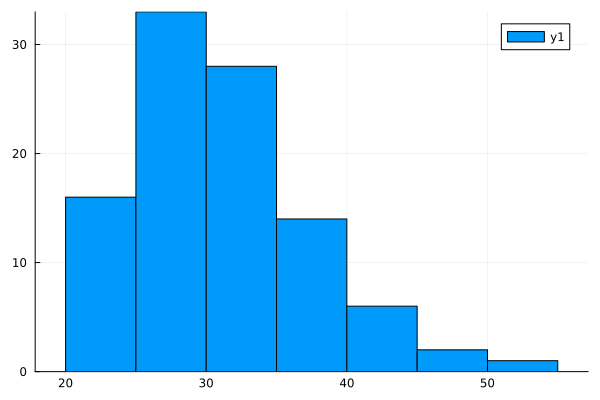

In [43]:
histogram(dfclust.a)

### Non-linear solver

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

We will then consider an approach **based on FOC**, which is useful to extend to strategic firms as in Bushnell, Mansur, and Saravia (2008) and Ito and Reguant (2016).

In perfect competition, the two approaches should be equivalent--and they are in my computer!

In [44]:
## Clear market based on cost minimization
function clear_market_min(data::DataFrame, tech::DataFrame; 
    wind_gw = 5.0, solar_gw = 2.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    S = 1;  # we will only be using one sector to keep things simple

    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);

    # Maximize welfare including imports costs
    @NLobjective(model, Max, sum(data.weights[t] * (
                price[t] * demand[t] + demand[t]^2/(2*data.b[t])
        - sum(tech.c[i] * quantity[t,i] 
                    + tech.c2[i] * quantity[t,i]^2/2 for i=1:I)
        - (imports[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

        
    # Constraints on output
    @constraint(model, [t=1:T], 
        quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= solar_gw * data.solar_cap[t]);
        
        
    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] 
                + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) 
                + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_min (generic function with 1 method)

In [45]:
results_min = clear_market_min(dfclust, tech)

Dict{String, Any} with 7 entries:
  "avg_price" => 33.8282
  "cost"      => 431.507
  "price"     => [40.7236, 38.3629, 55.0306, 26.0829, 36.1277, 34.8338, 39.9498…
  "status"    => "LOCALLY_SOLVED"
  "imports"   => [7.05655, 8.35099, 7.55272, 6.9851, 5.59969, 6.45185, 8.90446,…
  "demand"    => [33.5849, 29.9547, 42.4313, 22.1565, 23.6833, 21.553, 33.1884,…
  "quantity"  => [4.61597 11.5 … 2.40903 1.57117; 3.95377 11.5 … 2.05941 0.0146…

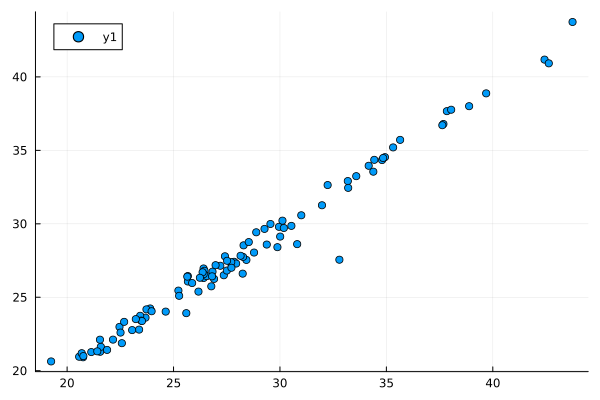

In [46]:
scatter(results_min["demand"],dfclust.demand)

In [47]:
results_more_wind = clear_market_min(dfclust, tech, wind_gw=15.0)

Dict{String, Any} with 7 entries:
  "avg_price" => 30.1602
  "cost"      => 342.149
  "price"     => [36.4589, 34.7635, 45.9731, 24.0362, 34.2806, 28.4836, 37.9167…
  "status"    => "LOCALLY_SOLVED"
  "imports"   => [6.84954, 8.12389, 7.23996, 6.82275, 5.51523, 6.12009, 8.77607…
  "demand"    => [33.9392, 30.2538, 43.1839, 22.3266, 23.8367, 22.0806, 33.3573…
  "quantity"  => [4.61597 11.5 … 7.22709 1.57117; 3.95377 11.5 … 6.17822 0.0146…

### Mixed integer solver

The key to the FOC representation is to model the marginal cost of power plants. The algorithm will be using power plants until $MC = Price$. 

**Note**: In the market power version of this algorithm, it sets $MR = MC$.

We will be using **integer variables** to take into consideration that FOC are not necessarily at an interior solution in the presence of capacity constraints.

If $Price < MC(0)$, a technology will not produce.

If $Price > MC(K)$, a technology is at capacity and can no longer increase output. In such case, the firm is earning a markup even under perfect competition. We define the shadow value as:

$\psi = Price - MC$

Shadow values define the rents that firms make. These are directly used in an expaded version of the model with investment.

We will define these conditions using binary variables (0 or 1):

* $u_1$ will turn on when we use a technology.
* $u_2$ will turn on when we use a technology at capacity. 
* $\psi$ can only be positive if $u_2=1$.

Compared to the previous approach:
* There will not be an objective function.

* We will use a solver for mixed integer programming (`HiGHS`).

In [48]:
## Clear market based on first-order conditions
function clear_market_foc(data::DataFrame, tech::DataFrame; 
    wind_gw = 5.0, solar_gw = 2.0, theta = 0.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            HiGHS.Optimizer)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    S = 1;  # we will only be using one sector to keep things simple

    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, shadow[1:T, 1:I] >= 0);  # price wedge if at capacity
    @variable(model, u1[1:T, 1:I], Bin);  # if tech used
    @variable(model, u2[1:T, 1:I], Bin);  # if tech at max

    @objective(model, Min, sum(price[t] * data.weights[t] for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Capacity constraints
    @constraint(model, [t=1:T], 
        quantity[t,1] <= u1[t,1] * data.hydronuc[t]); #we can only use the technology if u1 = 1
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= u1[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= u1[t,5] * wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= u1[t,6] * solar_gw * data.solar_cap[t]);

    @constraint(model, [t=1:T], 
        quantity[t,1] >= u2[t,1] * data.hydronuc[t]); #if u2 = u1 = 1, hydronuc <= q <= hydronuc
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] >= u2[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] >= u2[t,5] * wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,6] >= u2[t,6] * solar_gw * data.solar_cap[t]);

    @constraint(model, [t=1:T,i=1:I], u1[t,i] >= u2[t,i]);	

    # Constraints on optimality 
    M = 1e3;
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - theta * quantity[t,i]/(data.b[t]+data.bm[t]) - shadow[t,i] 
        >= -M * (1-u1[t,i]));
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - theta * quantity[t,i]/(data.b[t]+data.bm[t]) - shadow[t,i] 
        <= 0.0);
    @constraint(model, [t=1:T,i=1:I], shadow[t,i] <= M*u2[t,i]);

    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="OPTIMAL")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);		
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        shadow = JuMP.value.(shadow);
        u1 = JuMP.value.(u1);
        u2 = JuMP.value.(u2);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "shadow" => shadow,
            "u1" => u1,
            "u2" => u2);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_foc (generic function with 1 method)

In [49]:
results_foc = clear_market_foc(dfclust, tech)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+03]
  Cost   [7e-04, 2e-02]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+03]
Presolving model
3692 rows, 2496 cols, 9080 nonzeros  0s
3592 rows, 1369 cols, 5893 nonzeros  0s
1573 rows, 1072 cols, 4051 nonzeros  0s
1180 rows, 771 cols, 3030 nonzeros  0s
935 rows, 696 cols, 2392 nonzeros  0s
875 rows, 154 cols, 713 nonzeros  0s
34 rows, 18 cols, 72 nonzeros  0s
16 rows, 15 cols, 33 nonzeros  0s
6 rows, 2 cols, 4 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      33.8281538158
  Dual bound        33.8281538158
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    33.8281538158 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.02 (total)
                    0.02 (

Dict{String, Any} with 10 entries:
  "avg_price" => 33.8282
  "cost"      => 431.507
  "price"     => [40.7236, 38.3629, 55.0306, 26.0829, 36.1277, 34.8338, 39.9498…
  "status"    => "OPTIMAL"
  "imports"   => [7.05655, 8.35099, 7.55272, 6.9851, 5.59969, 6.45185, 8.90446,…
  "demand"    => [33.5849, 29.9547, 42.4313, 22.1565, 23.6833, 21.553, 33.1884,…
  "shadow"    => [30.7236 13.6319 … 40.7236 40.7236; 28.3629 11.2712 … 38.3629 …
  "u2"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [4.61597 11.5 … 2.40903 1.57117; 3.95377 11.5 … 2.05941 0.0146…

We can check that u1, u2 and the shadow values are correct. For example, at hour 1, tech 4 is not producing, while tech 3 is setting the price and therefore it does not have inframarginal rents (shadow = 0)

In [50]:
df_results = DataFrame(u1=results_foc["u1"][1,:],u2=results_foc["u2"][1,:],shadow=results_foc["shadow"][1,:])

Row,u1,u2,shadow
,Float64,Float64,Float64
1,1.0,1.0,30.7236
2,1.0,1.0,13.6319
3,1.0,0.0,0.0
4,0.0,0.0,0.0
5,1.0,1.0,40.7236
6,1.0,1.0,40.7236


In [51]:
results_foc_mp = clear_market_foc(dfclust, tech, theta=1.0)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+03]
  Cost   [7e-04, 2e-02]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+03]
Presolving model
3692 rows, 2496 cols, 9680 nonzeros  0s
3692 rows, 1447 cols, 6189 nonzeros  0s
1671 rows, 1141 cols, 4698 nonzeros  0s
1403 rows, 929 cols, 3880 nonzeros  0s
1131 rows, 830 cols, 3151 nonzeros  0s
1057 rows, 291 cols, 1549 nonzeros  0s
370 rows, 203 cols, 887 nonzeros  0s
223 rows, 195 cols, 548 nonzeros  0s
96 rows, 36 cols, 133 nonzeros  0s
10 rows, 6 cols, 21 nonzeros  0s
10 rows, 2 cols, 8 nonzeros  0s
4 rows, 2 cols, 8 nonzeros  0s

Solving MIP model with:
   4 rows
   2 cols (0 binary, 0 integer, 0 implied int., 2 continuous)
   8 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Con

Dict{String, Any} with 10 entries:
  "avg_price" => 61.8219
  "cost"      => 428.924
  "price"     => [79.7349, 69.0902, 113.77, 46.0712, 67.0134, 61.7278, 73.3398,…
  "status"    => "OPTIMAL"
  "imports"   => [8.95017, 10.2897, 9.58102, 8.5706, 7.01196, 7.85689, 11.013, …
  "demand"    => [30.3437, 27.4018, 37.5511, 20.4959, 21.1172, 19.3186, 30.4143…
  "shadow"    => [34.6653 0.0 … 61.4324 67.798; 32.0423 0.0 … 55.0017 68.9898; …
  "u2"        => [1.0 0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0; …
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [4.61597 7.11667 … 2.40903 1.57117; 3.95377 6.38246 … 2.05941 …

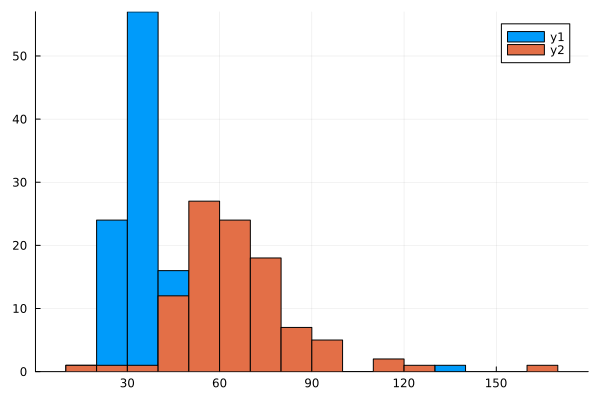

In [52]:
histogram(results_foc["price"], nbins=20)
histogram!(results_foc_mp["price"],nbins=20)

In [53]:
results_foc = clear_market_foc(dfclust, tech, theta=1.0)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+03]
  Cost   [7e-04, 2e-02]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+03]
Presolving model
3692 rows, 2496 cols, 9680 nonzeros  0s
3692 rows, 1447 cols, 6189 nonzeros  0s
1671 rows, 1141 cols, 4698 nonzeros  0s
1403 rows, 929 cols, 3880 nonzeros  0s
1131 rows, 830 cols, 3151 nonzeros  0s
1057 rows, 291 cols, 1549 nonzeros  0s
370 rows, 203 cols, 887 nonzeros  0s
223 rows, 195 cols, 548 nonzeros  0s
96 rows, 36 cols, 133 nonzeros  0s
10 rows, 6 cols, 21 nonzeros  0s
10 rows, 2 cols, 8 nonzeros  0s
4 rows, 2 cols, 8 nonzeros  0s

Solving MIP model with:
   4 rows
   2 cols (0 binary, 0 integer, 0 implied int., 2 continuous)
   8 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Con

Dict{String, Any} with 10 entries:
  "avg_price" => 61.8219
  "cost"      => 428.924
  "price"     => [79.7349, 69.0902, 113.77, 46.0712, 67.0134, 61.7278, 73.3398,…
  "status"    => "OPTIMAL"
  "imports"   => [8.95017, 10.2897, 9.58102, 8.5706, 7.01196, 7.85689, 11.013, …
  "demand"    => [30.3437, 27.4018, 37.5511, 20.4959, 21.1172, 19.3186, 30.4143…
  "shadow"    => [34.6653 0.0 … 61.4324 67.798; 32.0423 0.0 … 55.0017 68.9898; …
  "u2"        => [1.0 0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0; …
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [4.61597 7.11667 … 2.40903 1.57117; 3.95377 6.38246 … 2.05941 …

### Discussion of pros and cons:

* Mixed integer programming has advantages due to its robust finding of global solutions.

* Here, we are using first-order conditions, so a question arises regarding the validity of such conditions to fully characterize a unique solution in more general settings.

* Non-linear solvers explore the objective function but do not tend to be global in nature.

* Non-linear solvers cannot deal with an oligopolistic setting in a single model, as several agents are maximizing profits. We would need to iterate.

## Follow-up exercises

1. Imagine each technology is a firm, which now might exercise market power. Can you modify clear\_market\_foc to account for market power as in BMS (2008)? [in class]

2. The function is prepared to take several amounts of solar and wind. What are the impacts on prices as you increase solar and wind? Save prices for different values of wind or solar investment and plot them. Does your answer depend a lot on the number of clusters?

3. Making some assumptions on the fixed costs of solar and wind, can you expand the model to solver for investment? This will require a FOC for the zero profit entry condition. In Bushnell (2011) and Reguant (2019), that FOC might not be satisfied (zero investment), so it is also a complementarity problem.